# Importation des données

In [10]:
import os
import string
import re
import math
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)
np.random.seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

#PCA & TSNE : 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import spearmanr

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import seaborn as sns

import gensim
from gensim.models import word2vec

import rpy2.robjects as r

In [12]:
nom_dossier = "100k"
nom_dossier = "ens"
gensim_utile = True #True pour le modèle google, False pour le modele ARK

#os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')


with open("data/corpus_trie%s.file" %nom_dossier, "rb") as f:
    corpus = pickle.load(f) 
ens_tweets = [phrase.split() for phrase in corpus]
len(ens_tweets)

1348627

On crée index_mot et mot_index

In [13]:
phrases = ens_tweets
words = [item for sublist in phrases for item in sublist]
print(type(words))
with open('data/%s/vocabulary.file' %nom_dossier, "rb") as f:
    vocabulary = pickle.load(f) 
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))
fdist = nltk.FreqDist(words)

<class 'list'>
Nombre de mots : 31390592
Taille du vocabulaire : 70330


In [18]:
print(fdist.most_common(100))

[('nickname', 89694), ('lowfrequencyword', 66423), ('de', 39312), ('le', 25066), ('est', 20926), ('je', 20215), ('les', 18382), ('c', 17566), ('j', 17252), ('la', 16791), ('à', 16484), ('pas', 16183), ('que', 12219), ('en', 12111), ('un', 11109), ('et', 10640), ('a', 10056), ('ça', 9730), ('ai', 9054), ('l', 8607), ('mais', 8261), ('il', 8238), ('pour', 7845), ('tu', 7399), ('d', 7333), ('on', 7000), ('une', 6829), ('😂', 6829), ('me', 6183), ('qui', 5452), ('ce', 5403), ('t', 5233), ('😭', 5064), ('dans', 4904), ('plus', 4861), ('sur', 4809), ('mon', 4499), ('moi', 4444), ('suis', 4422), ('qu', 4334), ('y', 4143), ('avec', 3948), ('fait', 3942), ('bien', 3884), ('vous', 3801), ('trop', 3793), ('ma', 3637), ('si', 3608), ('tout', 3286), ('m', 3206), ('elle', 3180), ('va', 3149), ('faire', 3054), ('même', 3032), ('merci', 2786), ('toi', 2757), ('ne', 2748), ('bon', 2691), ('quand', 2678), ('mdr', 2578), ('oui', 2508), ('ils', 2481), ('comme', 2456), ('non', 2446), ('n', 2438), ('se', 2343

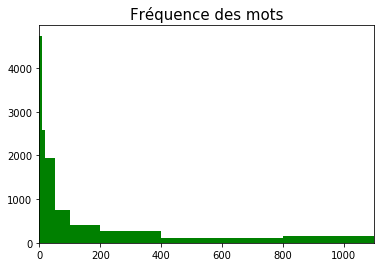

In [19]:
import matplotlib.pyplot as plt
plt.hist(fdist.values(), bins=[0,10,20,50, 100, 200,400,800,max(fdist.values())],color='g') #width=100, range=(0, 50000)
plt.xlim(xmin=0, xmax = 1100)
plt.title('Fréquence des mots', fontsize=15)
plt.show()

# Fonctions générales

## 1. Distances

Pour tester la similarité entre deux mots, on calcule la **similarité cosinus** entre leur représentation vectorielle :
$$
\frac{A \cdot B}{|| A || \cdot || B ||}
$$

On peut également calculer la **distance euclidienne** pour comparer les résultats avec ces deux métriques

In [14]:
def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))

def eucl_distance(u, v):
    return (1/(np.linalg.norm(u/np.dot(u, u)-v/np.dot(v, v)))+1)

Cette fonction permet d'afficher les n mots les plus proche d'un mot (distance cosinus ou euclidienne)

In [15]:
def mot_plus_proche(word, n=10, distance="cos"):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            if distance == "cos":
                word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
            else:
                word_distance[mot] = (eucl_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]

Cette fonction permet de calculer la distance entre deux mots. 

In [16]:
def distance_mots(word1,word2, mot_poids, distance="cos"):
    if word1 in mot_poids.keys() and word2 in mot_poids.keys():
        if(distance=="cos"):
            word_distance = (cos_distance(mot_poids[word1],(mot_poids[word2])))
        else:
            word_distance = (eucl_distance(mot_poids[word1],(mot_poids[word2])))
    else:
        word_distance = float('nan')
    return word_distance
distance_mots_v = np.vectorize(distance_mots)

# Evaluer un seul modèle 

Ecrire les bilans ici : https://github.com/AQLT/StatApp/blob/master/Code/Parametres%20lances.md


## 1. Charger le modèle


Paramètres à modifier 

In [23]:
if gensim_utile: # Pour le modèle Google
    # renseigner dans l'ordre : dim, epoch, window, learning_rate
    simul = [50,100,3,0.01] # une seule simulation dans cette partie
    dim = simul[0]
    epoch = simul[1]
    window = simul[2]
    learning_rate = simul[3]
    seed = 1
else: # Pour le modèle ARK (à modifier ultérieurement avec nouveau nommage)
    numero_simulation = 2
    seed = 1
    derniere_epoch = 10 

In [24]:
if gensim_utile: # Pour le modèle Google
    #chemin = "data/" + nom_dossier + "/gensim/Simulation_" + str(numero_simulation) +"_seed"+ str(seed)
    chemin = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed{}".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:], seed)  
    model = gensim.models.keyedvectors.KeyedVectors.load(chemin + "/word2vec.model")
    py_list = []
    for mot in vocabulary:
         py_list.append(model.wv[mot].tolist())   
    mat_finale = torch.FloatTensor(py_list)
else: # Pour le modèle ARK (à modifier ultérieurement avec nouveau nommage)
    with open('data/%s/Simulation_%i_seed%i/input_%i.file' %(nom_dossier, numero_simulation, seed, derniere_epoch) , "rb") as f:
        input = pickle.load(f)
    with open('data/%s/Simulation_%i_seed%i/output_%i.file' %(nom_dossier, numero_simulation, seed, derniere_epoch), "rb") as f:
        output = pickle.load(f)
    mat_finale = (input+output)/2 
    
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}

## 2. Mots les plus proches

In [25]:
mots = ["tweet", "bonjour", "wesh", "gros", "grosse", "femme","romain"]
for mot in mots:
    if mot in mot_index:
        print('Pour le mot "%s"' %mot + " (%i apparitions), les mots les plus proches sont : " %fdist[mot])
        print('cosinus :',mot_plus_proche(mot,distance = "cos"))
        print('euclidienne :',mot_plus_proche(mot,distance = "eucl"))
        print("\n")

Pour le mot "tweet" (443 apparitions), les mots les plus proches sont : 
cosinus : [('point', 0.9084009101113713), ('sujet', 0.8591538969161496), ('jeu', 0.8458192655919179), ('moment', 0.8241824110470765), ('film', 0.8177886181442553), ('gif', 0.8171320399068367), ('mot', 0.8029144145095303), ('coeur', 0.759854953239474), ('mec', 0.759425501687425), ('joueur', 0.7574747267538198)]
euclidienne : [('point', 12.5259727361733), ('moment', 10.724800443311178), ('jeu', 9.535179435757984), ('cas', 9.212999693797153), ('mec', 9.141429123419773), ('film', 9.117160513306908), ('truc', 9.089707466115112), ('coeur', 8.654007895018674), ('compte', 8.627719175610435), ('coup', 8.39443540309776)]


Pour le mot "bonjour" (619 apparitions), les mots les plus proches sont : 
cosinus : [('bonsoir', 0.8845197876354314), ('hello', 0.8527229034585722), ('pensez', 0.8241578967046451), ('savez', 0.8216388728785031), ('saviez', 0.8087990765431533), ('dites', 0.7963558035315687), ('contacter', 0.78945627196719

## 3. Réduction de dimension (ACP, TSNE)

### A. Listes de mots utilisées

**Liste 1** correspond à une liste de mot que nous choississons nous-même d'évaluer. 

In [26]:
liste1 = [["poli","courtois","bonjour","salut"],["canapé","fauteuil","table","chaise"],
    ["téléphone","portable","numéro","appel"],["voiture","camion","vélo","train"],
         ["beau","mignon","bg","mannequin"],["docteur","médecin","santé","bobo"],
         ["belle","jolie","mignonne","bellegosse"],["père","papa","daron"],
         ["mère","maman","daronne"],["ol","psg","foot","stade"]]

#liste1 = [["homme","femme", "enfant"],["chien","chat"],
#         ["vanille","chocolat"],
#    ["poli","courtois"],["bonjour","salut"],["propre","sale"],["canapé","fauteuil"],
#    ["téléphone","portable"],["voiture","camion"],["grand","petit"]]

#liste1 = [["homme", "tttttttttt","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],
#    ["chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
#    ["vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
#    ["poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
#    ["choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
#    ["propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
#    ["canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
#    ["téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
#    ["voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
#    ["grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"]
#]

**Liste 2** tire au sort une liste de mots regroupés selon leur fréquence d'apparition. 

In [27]:
np.random.seed(1)

mots0_20 = dict()
mots20_100 = dict()
mots100_1000 = dict()
mots1000_max = dict()

for (key, value) in fdist.items():
    if value <= 20 :
        mots0_20[key] = value
    if value > 20 and value <= 100 :
        mots20_100[key] = value
    if value > 100 and value <= 1000 :
        mots100_1000[key] = value        
    if value > 1000 :
        mots1000_max[key] = value


liste_0_20 = list(np.random.choice(list(mots0_20.keys()), size=100))
liste_20_100 = list(np.random.choice(list(mots20_100.keys()), size=100))
liste_100_1000 = list(np.random.choice(list(mots100_1000.keys()), size=100))
liste_1000_max = list(np.random.choice(list(mots1000_max.keys()), size=100))

liste2 = [liste_0_20, liste_20_100, liste_100_1000, liste_1000_max]

### B. ACP

In [28]:
def ACP(liste, statique = True, nom_couples_explicite=True):
    # On enlève les mots qui n'existent pas
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index]) 
    liste_mots = [w for couple in liste_triee for w in couple]

    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i        

    features = list(range(0, len(liste_triee)))
    # Separating out the features
    x = df_res.loc[:, features].values
    # Separating out the target
    y = df_res.loc[:,['label']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['Axe 1', 'Axe 2'])

    df_res['mot'] = df_res.index.values
    df_res = df_res.reset_index()

    finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)

    if statique:
        # Représentation simple statique 
        fig = plt.figure(figsize = (12,8))

        g = sns.scatterplot(x="Axe 1", y="Axe 2",
                        hue="label", data=finalDf, s = 150)
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(finalDf["label"])))
    else:
        init_notebook_mode(connected=True)

        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        #subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)
        subFinalDf = pd.concat([finalDf],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='Axe 1',
                      y='Axe 2',
                      categories='label',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='ACP en 2 composantes',
                      filename='cufflinks/simple-scatter')


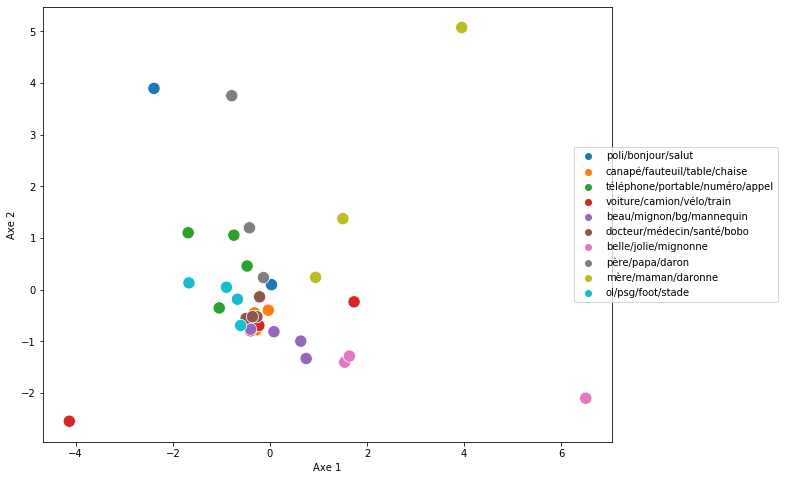

In [29]:
ACP(liste1, statique = True)

In [30]:
ACP(liste1, statique = False)

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [31]:
ACP(liste2, statique = False)

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



## 4. TSNE 

In [32]:
def tsne_graph(liste, statique = True, nom_couples_explicite=True):
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index])
    liste_mots = [w for couple in liste_triee for w in couple]
    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i  
    features = list(range(0, len(liste)))
    # Separating out the features
    data_x = df_res.loc[:, features].values
    # Separating out the target
    data_y = df_res.loc[:,['label']].values

    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj= tsne.fit_transform(data_x)

    test_features = [[i+1]*len(liste_triee[i]) for i in range(0, len(liste_triee))]
    test_features = [i for f in test_features for i in f]
    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                            'Y':tsne_obj[:,1],
                           'digit':test_features})
    tsne_df["legend"] = tsne_df["digit"]
    for i in range(0,len(tsne_df)):
        tsne_df["legend"][i]= "Couple %i" %tsne_df["digit"][i]
    if statique:
        fig = plt.figure(figsize = (12,8))
        g = sns.scatterplot(x="X", y="Y",
                            hue = "legend",
                            data=tsne_df);
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(tsne_df["legend"])))
    else:
        tsne_df["mot"] = liste_mots
        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        subFinalDf = pd.concat([tsne_df],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='X',
                      y='Y',
                      categories='legend',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='TSNE',
                      filename='cufflinks/simple-scatter')

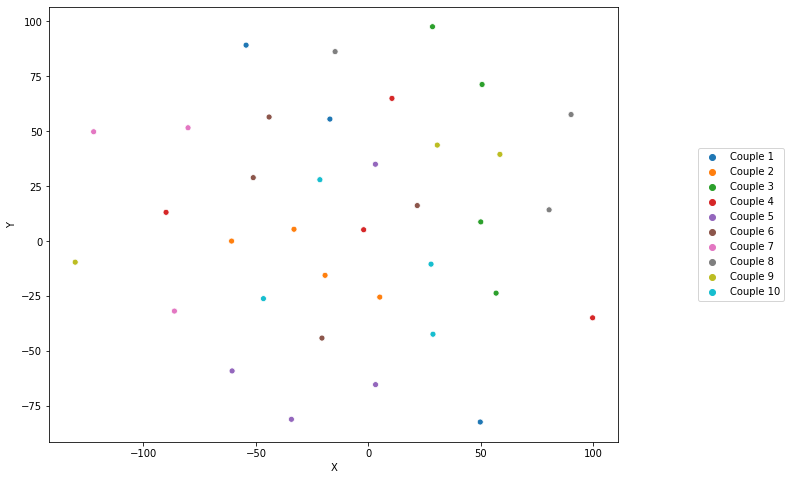

In [33]:
tsne_graph(liste1, statique = True,
           nom_couples_explicite = True) #Paramètre ne marche pas : a debuger ?

In [34]:
tsne_graph(liste1, statique = False,
           nom_couples_explicite = True) #Paramètre ne marche pas : a debuger ?


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [35]:
tsne_graph(liste2, statique = False,
           nom_couples_explicite = True)#Paramètre ne marche pas : a debuger ?

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



## 5. Human judgement

In [37]:
df_base = pd.read_csv('data_bis/word_similarity.csv', sep=";")
df_base

,word1,word2,corr
0,corde,sourire,0.00
1,midi,ficelle,0.00
2,coq,périple,0.06
3,fruit,fournaise,0.11
4,autographe,rivage,0.00
...,...,...,...
60,coussin,oreiller,3.00
61,cimetière,cimetière,4.00
62,automobile,auto,3.94
63,joyau,bijou,3.22


In [38]:
distance_mots_v = np.vectorize(distance_mots)
df = df_base
df["corr_word2vec_cos"] = distance_mots_v(df["word1"],df["word2"], mot_poids, "cos")
df["corr_word2vec_eucl"] = distance_mots_v(df["word1"],df["word2"], mot_poids, "eucl")
print(len(df))
df = df.dropna()
print(len(df))
df

65
13


,word1,word2,corr,corr_word2vec_cos,corr_word2vec_eucl
0,corde,sourire,0.00,0.643796,1.863783
16,côte,forêt,0.22,0.868877,2.759573
20,garçon,sage,0.29,0.709429,2.939884
23,gars,sorcier,0.44,0.139455,1.796270
28,oiseau,bois,0.06,0.630483,2.187629
33,auto,voyage,0.33,0.596326,2.986266
35,verre,bijou,0.56,0.851264,1.844745
38,frère,gars,2.00,0.699675,7.277666
39,sage,sorcier,0.83,0.780883,2.197992
43,nourriture,fruit,2.78,0.952832,4.520307


In [39]:
#On fait des tests à 5 % pour la distance cosinus
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec_cos"])
if p_value > alpha:
    print('Le résultat de word2vec COSINUS est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec COSINUS est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

print("\n")

#On fait des tests à 5 % pour la distance euclidienne
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec_eucl"])
if p_value > alpha:
    print('Le résultat de word2vec EUCLIDIEN est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec COSINUS est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

Le résultat de word2vec COSINUS est différent de celui du human judgement (non rejet de H0 = non corrélation) p=0.887 / Valeur de la corrélation : -0.044


Le résultat de word2vec EUCLIDIEN est différent de celui du human judgement (non rejet de H0 = non corrélation) p=0.334 / Valeur de la corrélation : 0.291


# Evaluer plusieurs modèles 

## 1. Evaluation par le "human judgement"


In [17]:
def corr_modele(chemin, distance="cos", gensimbool = gensim_utile, epoch_max = 50):  
    all_cor = []
    all_p_val = []
    if gensimbool:
        #chemin = "data/" + nom_dossier + "/gensim/Simulation_" + str(numero_simulation) + dossier
        #chemin = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed{}".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:], seed)  
        isdir = os.path.isdir(chemin)
        if isdir:
            model = gensim.models.keyedvectors.KeyedVectors.load(chemin + "/word2vec.model")
            py_list = []
            for mot in vocabulary:
                py_list.append(model.wv[mot].tolist())   
            mat_finale = torch.FloatTensor(py_list)
            mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
            df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
            df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids, distance)
            df = df.dropna()
            corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
            all_cor.append(corr)
            all_p_val.append(p_value)
    else:
        isdir = os.path.isdir(chemin)
        if isdir:
            for i in range(epoch_max):
                try:
                    with open('{}/input_{}.file'.format(chemin, i+1), "rb") as f:
                        input = pickle.load(f)
                    with open('{}/output{}.file'.format(chemin, i+1), "rb") as f:
                        output = pickle.load(f)
                    mat_finale = (input+output)/2
                    mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
                    df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
                    df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids, distance)
                    df = df.dropna()
                    corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
                    all_cor.append(corr)
                    all_p_val.append(p_value)
                except OSError:
                    break;     
        
    return([all_cor, all_p_val]);

#corr_modele("data/100k/gensim/dim20_ep10_w3_lr01_seed1", distance="cos", gensimbool = True, epoch_max = 50)

In [73]:
def tableau_corr_hji(dim = "\d*", epoch = "\d*", window = "\d*",
                     learning_rate = "\d*", seed = "\d*",
                     distance="cos", index = "seed", gensimbool = gensim_utile):    
    if(isinstance(learning_rate, float)):
        learning_rate = str(learning_rate)[2:]
    if(isinstance(dim, list)):
        dim = r.r['paste0']("(",r.r['paste0']("(",dim,")",collapse = "|"),")")[0]
    if(isinstance(epoch, list)):
        epoch = r.r['paste0']("(",r.r['paste0']("(",epoch,")",collapse = "|"),")")[0]
    if(isinstance(window, list)):
        window = r.r['paste0']("(",r.r['paste0']("(",window,")",collapse = "|"),")")[0]
    if(isinstance(learning_rate, list)):
        learning_rate = [str(lr)[2:] if isinstance(lr, float) else lr for lr in learning_rate]
        learning_rate = r.r['paste0']("(",r.r['paste0']("(",learning_rate,")",collapse = "|"),")")[0]
    if(isinstance(seed, list)):
        seed = r.r['paste0']("(",r.r['paste0']("(",seed,")",collapse = "|"),")")[0]

    requete_regexp = 'dim{}_ep{}_w{}_lr{}_seed{}'.format(dim, epoch, window, learning_rate, seed)
    if gensimbool:
        gensim_st = "gensim/"
    else:
        gensim_st = ""
    dossiers = r.r['list.files'](path = 'data/{}/{}'.format(nom_dossier, gensim_st),
                      pattern = requete_regexp)
    dossiers = [dossiers[i] for i in range(len(dossiers))]
    #dossiers = r.r['paste0']('data/{}/{}'.format(nom_dossier, gensim_st),dossiers)
    
    resultats = []
    nom_cols = dossiers

    for dossier in dossiers:
        #nom_cols.append( "dim{}_ep{}_lr{}_w{}".format(simul[0], simul[1], simul[2], str(simul[3])[2:]))
        #print(nom_cols)
        resultats.append(corr_modele(chemin = 'data/{}/{}{}'.format(nom_dossier, gensim_st, dossier), 
                                 distance= distance,gensimbool = gensimbool))
    max_len = max([len(x[0]) for x in resultats])
    for i in range(len(resultats)):
        if(len(resultats[i][0])<max_len):
            resultats[i][0] = resultats[i][0] +[np.nan]*(max_len - len(resultats[i][0]))
            resultats[i][1] = resultats[i][1] +[np.nan]*(max_len - len(resultats[i][1]))
    #nom_lignes = [re.sub('_seed', 'Seed ', d) if d != "" else "Pas de seed" for d in dossiers ]
    #nom_lignes = ["Seed " + str(s) for s in seeds]
    dossiers_sep = [string.split('_') for string in dossiers]
    all_dim = [r.r['grep']("^dim", x, value = True)[0] for x in dossiers_sep]
    all_dim = [r.r['paste0']("dim=", r.r['gsub']("dim", "", x))[0] for x in all_dim] 
    all_ep = [r.r['grep']("^ep", x, value = True)[0] for x in dossiers_sep]
    all_ep = [r.r['paste0']("ep=", r.r['gsub']("ep", "", x))[0] for x in all_ep] 
    all_w = [r.r['grep']("^w", x, value = True)[0] for x in dossiers_sep]
    all_w = [r.r['paste0']("w=", r.r['gsub']("w", "", x))[0] for x in all_w] 
    all_lr = [r.r['grep']("^lr", x, value = True)[0] for x in dossiers_sep]
    all_lr = [r.r['paste0']("lr=0.", r.r['gsub']("lr", "", x))[0] for x in all_lr] 
    all_seed = [r.r['grep']("^seed", x, value = True)[0] for x in dossiers_sep]
    all_seed = [r.r['paste0']("seed=", r.r['gsub']("seed", "", x))[0] for x in all_seed] 
    
    all_name = [all_dim, all_ep, all_w, all_lr, all_seed]


    #all_ep = r.r['grep']("^ep", x, value = True)
    #all_ep = [all_ep[0] for x in dossiers_sep]
    #all_w = r.r['grep']("^w", x, value = True)
    #all_w = [all_w[0] for x in dossiers_sep]
    #all_lr = [r.r['grep']("^lr", x, value = True)[0] for x in dossiers_sep]
    #all_seed = [r.r['grep']("^seed", x, value = True)[0] for x in dossiers_sep]
    #lr=0.01\n w=3\n e=10
    
    correspondance = {'dim': 0,
                  'epoch': 1,
                  'window': 2,
                  'learning_rate': 3,
                 'seed': 4}
    if not isinstance(index, list):
        index = [index]
    index_num = [correspondance[i] for i in index]
    indexs = [all_name[i] for i in [0,1,2,3,4] if i in index_num ]
    column = [all_name[i] for i in [0,1,2,3,4] if i not in index_num]
    lignes = list(map("\n".join, zip(*indexs)))
    colonnes = list(map("\n".join, zip(*column)))
    pivot_df = pd.DataFrame({'lignes': lignes,
                  'colonnes': colonnes})
    
    all_cor = pd.DataFrame([elem[0] for elem in resultats])
    all_p_val = pd.DataFrame([elem[1] for elem in resultats])
    all_cor.columns = all_p_val.columns = ["values"]
    

    all_cor = pd.concat([pivot_df, all_cor], axis=1)
    all_cor = all_cor.pivot(index = "lignes", columns = "colonnes", values = 'values')
    all_p_val = pd.concat([pivot_df, all_p_val], axis=1)
    all_p_val = all_p_val.pivot(index = "lignes", columns = "colonnes", values = 'values')
    
    # Pour enlever les noms ajouté par la fonction pivot
    all_cor = all_cor.rename_axis(None, axis=1)  
    all_cor = all_cor.rename_axis(None, axis=0)
    all_p_val = all_p_val.rename_axis(None, axis=1)  
    all_p_val = all_p_val.rename_axis(None, axis=0)
    return([all_cor, all_p_val])

In [74]:
# Exemple : dim20_ep10_w3_lr01_seed1 et dim50_ep10_w3_lr01_seed1
#resultats_hji = tableau_corr_hji(dim = [20,50], learning_rate = 0.01,
#                       window = 3, epoch = 10, index="seed",
#                       distance = "cos")[0]

# Explication : on peut fixer ou nom certains paramètres : par défaut on va chercher tous les dossiers disponibles
# Par exemple si on ne met pas le paramètre learning_rate, le programme va cherche 0.01 et 0.02 (s'ils existent)
# le paramètre index permet de définir les paramètres que l'on veut en ligne. Si l'on souhaite en mettre 2 faire une liste
# par exemple ["seed", "dim"]
resultats_hji = tableau_corr_hji(learning_rate = [0.01,0.02],
                       window = [3,4,5], dim = 50, index="seed",
                       distance = "cos")[0]
# Pour mettre dans l'ordre les lignes
resultats_hji = resultats_hji.reindex(index = ['seed=1','seed=5','seed=10','seed=15','seed=20','seed=25'])

##Il faut installer pandas 1.0 et tabulate
#print(resultats_hji)
print(resultats_hji.to_markdown())

|         |    dim=50 |    dim=50 |    dim=50 |    dim=50 |    dim=50 |    dim=50 |
|         |    ep=100 |    ep=100 |    ep=100 |    ep=100 |    ep=100 |    ep=100 |
|         |       w=3 |       w=3 |       w=4 |       w=4 |       w=5 |       w=5 |
|         |   lr=0.01 |   lr=0.02 |   lr=0.01 |   lr=0.02 |   lr=0.01 |   lr=0.02 |
|:--------|----------:|----------:|----------:|----------:|----------:|----------:|
| seed=1  |  0.446073 |  0.46666  |  0.443115 |  0.45602  |  0.44086  |  0.497009 |
| seed=5  |  0.429793 |  0.457739 |  0.449492 |  0.464523 |  0.441876 |  0.495642 |
| seed=10 |  0.43803  |  0.443842 |  0.463711 |  0.497436 |  0.451158 |  0.437048 |
| seed=15 |  0.445337 |  0.409657 |  0.501271 |  0.44961  |  0.454353 |  0.499904 |
| seed=20 |  0.452996 |  0.522679 |  0.482513 |  0.460848 |  0.437048 |  0.474907 |
| seed=25 |  0.446277 |  0.447175 |  0.455218 |  0.467942 |  0.43492  |  0.454534 |


In [70]:
from matplotlib.lines import Line2D

def intervalles_confiance (resultats_hji, distance = "cos"):
    colors = sns.color_palette("hls", 6)
    fig = plt.figure(figsize = (12,6))    
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    corr = resultats_hji
    corr = corr.reindex(index = ['seed=1','seed=5','seed=10','seed=15','seed=20','seed=25'])
    # ax.set_ylim(-0.5,0.6) # seulement si besoin pour faire des graph comparables
    ax.set_xlim(-0.2,len(corr.columns)-1+.2)

    for i in range(len(corr.columns)):
        corr_values = corr.iloc[:,i].values.tolist()
        ec = np.std(corr_values)
        moy = np.mean(corr_values)
        print(moy)
        icm = moy - 1.96 * ec
        icp = moy + 1.96 * ec
        ax.errorbar(i, moy, yerr=1.96 * ec,ecolor = "black", alpha = 0.5) 
        ax.scatter([i]*len(corr_values), corr_values, c=colors, s = 100) 
        ax.errorbar(i, moy, xerr=0.1, ecolor = "black", alpha= 0.5)
        
    ax.set_xticks(list(range(len(corr.columns))))
    #ax.set_xticklabels(["Simul. n°%i" %simul[i] for i in list(range(len(simul)))])
    ax.set_xticklabels(corr.columns.values.tolist())
    #ax.set_xticklabels(["lr=0.01\n w=3\n e=10","lr=0.01\n w=4\n e=10","lr=0.01\n w=5\n e=10",
    #                    "lr=0.02\n w=3\n e=10","lr=0.02\n w=4\n e=10","lr=0.02\n w=5\n e=10",
    #                    "lr=0.01\n w=3\n e=100","lr=0.01\n w=4\n e=100","lr=0.01\n w=5\n e=100",
    #                    "lr=0.02\n w=3\n e=100","lr=0.02\n w=4\n e=100","lr=0.02\n w=5\n e=100"])
    plt.ylabel("Corrélation entre la distance " + distance + " et le l'indice de jugement humain")
    plt.xlabel("Simulation avec "+ nom_dossier +" tweets")
    custom_lines=[]
    for i in range(len(colors)):
        custom_lines.append(Line2D([0], [0], marker='o', color='w',
                                   label='Scatter',markerfacecolor=colors[i], markersize=10))
    ax.legend(custom_lines, ['Seed 1','Seed 5','Seed 10','Seed 15','Seed 20','Seed 25'])

0.44308439367966973
0.45795863022307387
0.46588672782389046
0.4660633227615642
0.4433692568329261
0.4765071866078861


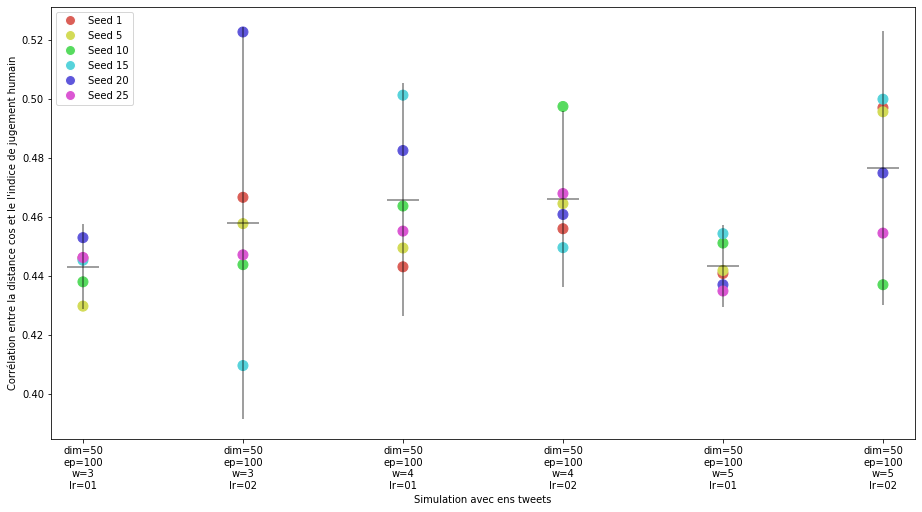

In [71]:
intervalles_confiance(resultats_hji)

0.03296703296703297
-0.010989010989010985
-0.022893772893772892
0.2591575091575091
0.326007326007326
0.2802197802197802
0.3836996336996337
0.3965201465201465
0.4276556776556777
0.3452380952380952
0.3717948717948718
0.3534798534798535


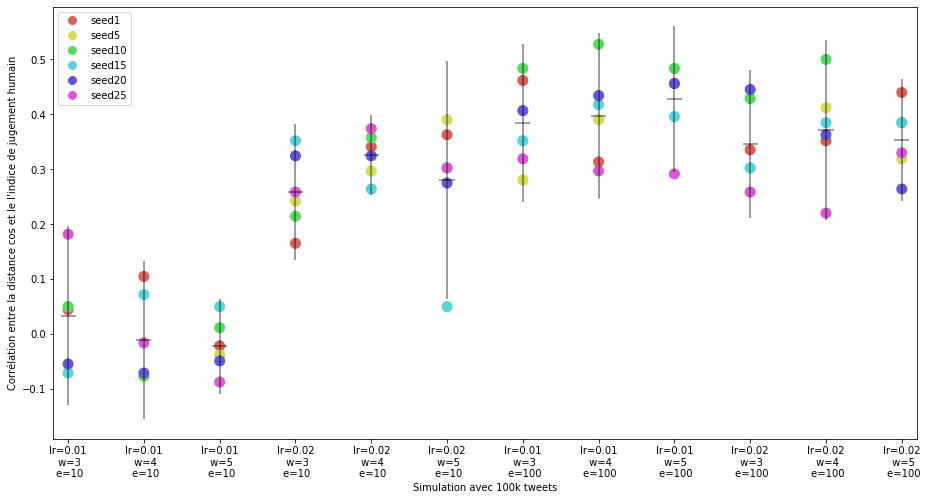

In [25]:
simul2 = [13,14,15,16,17,18,19,20,21,22,23,24]
intervalles_confiance(simul2, "cos")

-0.30036630036630035
-0.26373626373626374
-0.2738095238095238
-0.27930402930402926
-0.2371794871794872
-0.25366300366300365
-0.2371794871794872
-0.2353479853479854
-0.2564102564102564
-0.2692307692307693
-0.2490842490842491
-0.24450549450549453


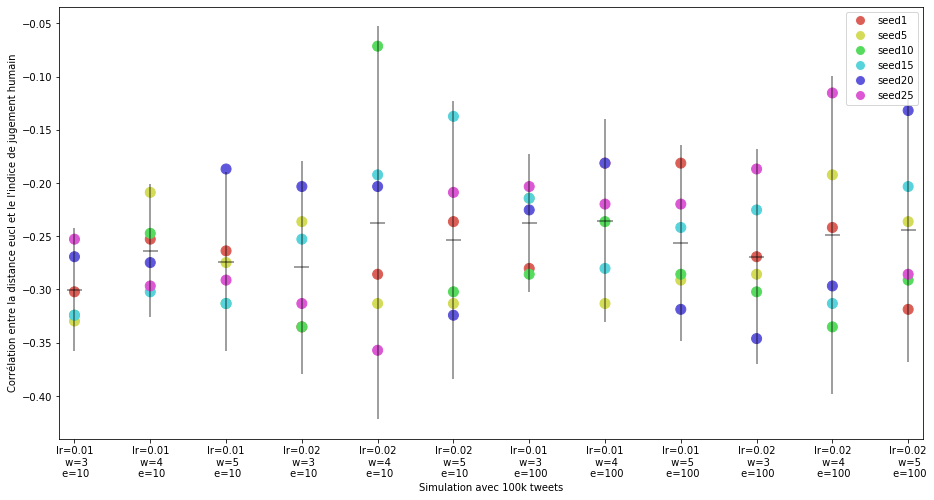

In [26]:
intervalles_confiance(simul2, "eucl")

Fonction Romain provisoire pour tests de représentations graphiques. 

-0.1886446886446886
0.03296703296703297
-0.20238095238095236
-0.010989010989010985
-0.1858974358974359
-0.022893772893772892
0.3095238095238095
0.2591575091575091
0.24267399267399267
0.326007326007326
0.10256410256410257
0.2802197802197802
0.4047619047619047
0.3836996336996337
0.4523809523809524
0.3965201465201465
0.41483516483516486
0.4276556776556777
0.4551282051282051
0.3452380952380952
0.43956043956043955
0.3717948717948718
0.4166666666666667
0.3534798534798535


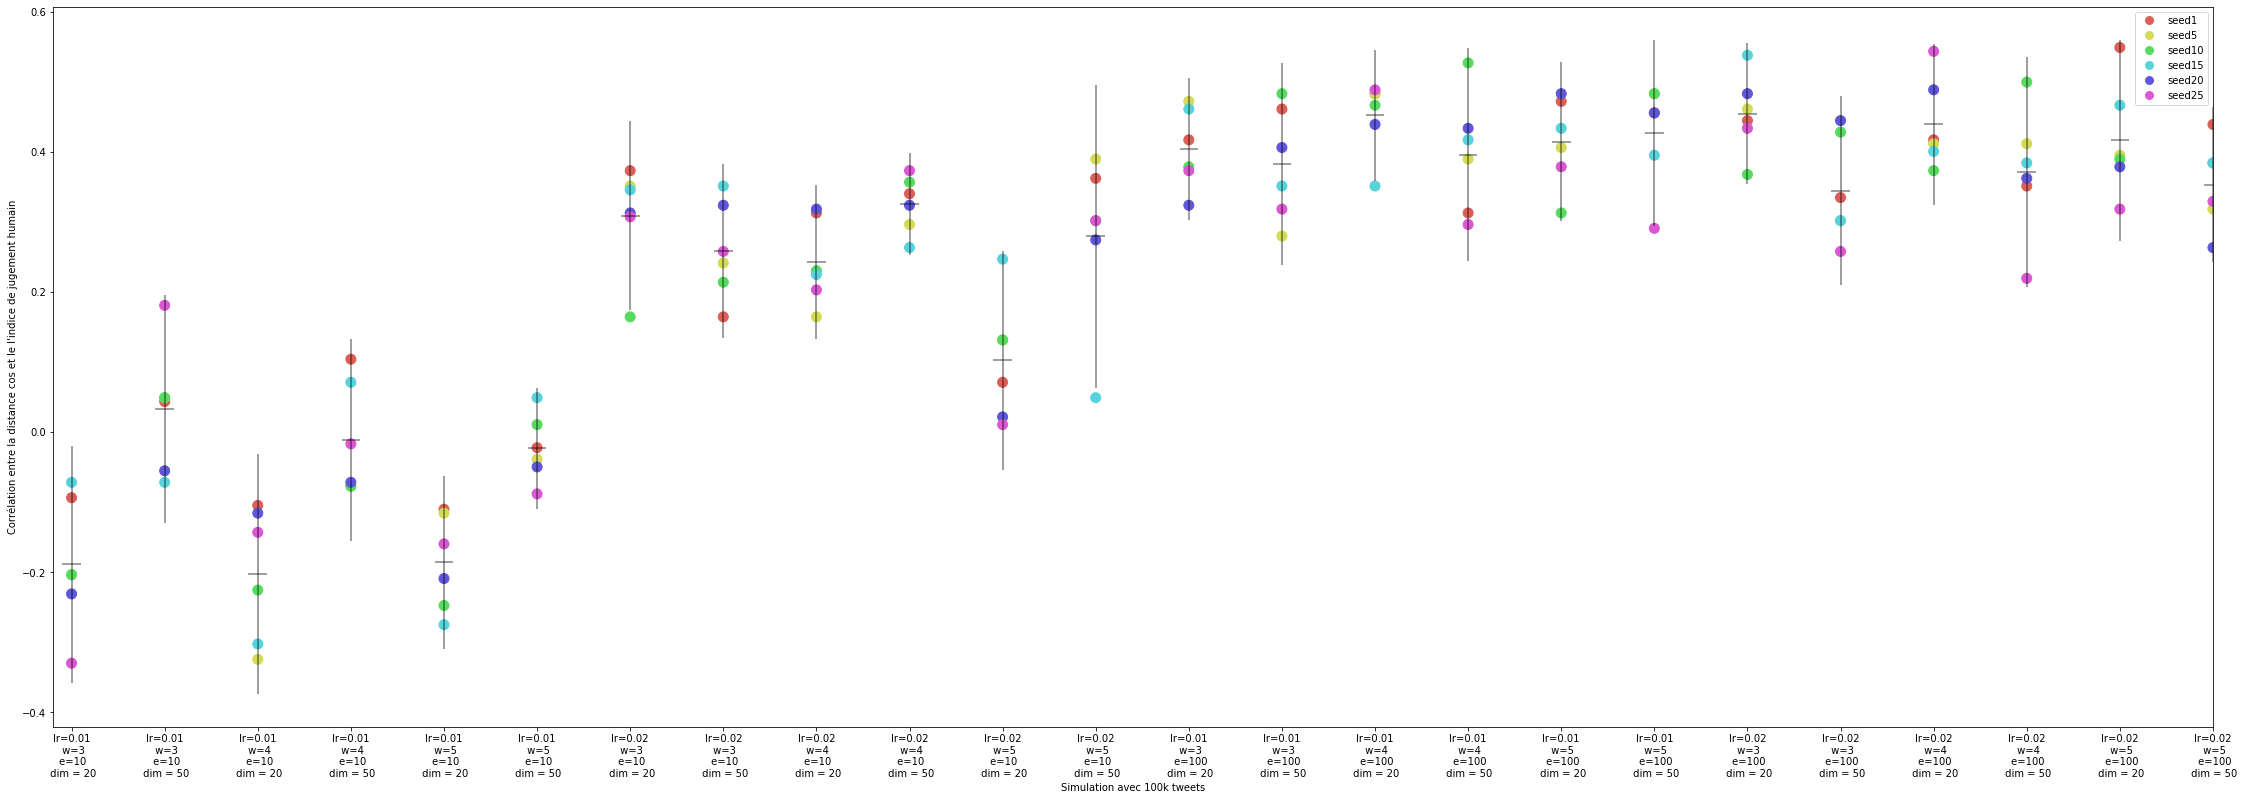

In [32]:
simul3 = [1,13,2,14,3,15,4,16,5,17,6,18,7,19,8,20,9,21,10,22,11,23,12,24]
def intervalles_confiance2(simulations, distance = "cos"):
    colors = sns.color_palette("hls", 6)
    fig = plt.figure(figsize = (30,10))    
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    ax.set_xlim(-0.2,len(simulations)-1+.2)
   # ax.set_ylim(-0.5,0.6) # seulement si besoin pour faire des graph comparables
    for i in range(len(simulations)):
        corr = tableau_corr_hji(dossiers, distance = distance, numero_simulation = simulations[i])[0]
        corr_values = corr.iloc[:,-1].values.tolist()
        ec = np.std(corr_values)
        moy = np.mean(corr_values)
        print(moy)
        icm = moy - 1.96 * ec
        icp = moy + 1.96 * ec
        ax.errorbar(i, moy, yerr=1.96 * ec,ecolor = "black", alpha = 0.5) 
        ax.scatter([i]*len(corr_values), corr_values, c=colors, s = 100) 
        ax.errorbar(i, moy, xerr=0.1, ecolor = "black", alpha= 0.5)
        
    ax.set_xticks(list(range(len(simulations))))
    #ax.set_xticklabels(["Simul. n°%i" %simul[i] for i in list(range(len(simul)))])
    ax.set_xticklabels(["lr=0.01\n w=3\n e=10\n dim = 20","lr=0.01\n w=3\n e=10\n dim = 50",
                        "lr=0.01\n w=4\n e=10\n dim = 20","lr=0.01\n w=4\n e=10\n dim = 50",
                        "lr=0.01\n w=5\n e=10\n dim = 20","lr=0.01\n w=5\n e=10\n dim = 50",
                        "lr=0.02\n w=3\n e=10\n dim = 20","lr=0.02\n w=3\n e=10\n dim = 50",
                        "lr=0.02\n w=4\n e=10\n dim = 20","lr=0.02\n w=4\n e=10\n dim = 50",
                        "lr=0.02\n w=5\n e=10\n dim = 20","lr=0.02\n w=5\n e=10\n dim = 50",
                        "lr=0.01\n w=3\n e=100\n dim = 20","lr=0.01\n w=3\n e=100\n dim = 50",
                        "lr=0.01\n w=4\n e=100\n dim = 20","lr=0.01\n w=4\n e=100\n dim = 50",
                        "lr=0.01\n w=5\n e=100\n dim = 20","lr=0.01\n w=5\n e=100\n dim = 50",
                        "lr=0.02\n w=3\n e=100\n dim = 20","lr=0.02\n w=3\n e=100\n dim = 50",
                        "lr=0.02\n w=4\n e=100\n dim = 20","lr=0.02\n w=4\n e=100\n dim = 50",
                        "lr=0.02\n w=5\n e=100\n dim = 20","lr=0.02\n w=5\n e=100\n dim = 50"
                       ])
    plt.ylabel("Corrélation entre la distance " + distance + " et le l'indice de jugement humain")
    plt.xlabel("Simulation avec "+ nom_dossier +" tweets")
    custom_lines=[]
    for i in range(len(colors)):
        custom_lines.append(Line2D([0], [0], marker='o', color='w',
                                   label='Scatter',markerfacecolor=colors[i], markersize=10))
    ax.legend(custom_lines, [string[1:] for string in dossiers])
intervalles_confiance2(simul3, "cos")